# How to use

In [1]:
import torch
import numpy as np
import SimpleITK as sitk
from matplotlib import pyplot as plt
from ptimz.utils.viz import plot_semseg
from ptimz import load_image

## Use ptimz to load deep learning models

In [2]:
import ptimz

list all models

In [3]:
print(ptimz.list_models())

['cyclegan_2d', 'litehrnet_cls2d', 'litehrnet_cls3d', 'litehrnet_seg2d', 'litehrnet_seg3d', 'resnet10_1d', 'resnet10_2d', 'resnet10_3d', 'resnet10d_1d', 'resnet10d_2d', 'resnet10d_3d', 'resnet18_1d', 'resnet18_2d', 'resnet18_3d', 'resnet18d_1d', 'resnet18d_2d', 'resnet18d_3d', 'resnet34_1d', 'resnet34_2d', 'resnet34_3d', 'resnet34d_1d', 'resnet34d_2d', 'resnet34d_3d', 'resnet50_1d', 'resnet50_2d', 'resnet50_3d', 'resnet50d_1d', 'resnet50d_2d', 'resnet50d_3d', 'resnet50unet_1d', 'resnet50unet_2d', 'resnet50unet_3d', 'resnet101_1d', 'resnet101_2d', 'resnet101_3d', 'resnet101d_1d', 'resnet101d_2d', 'resnet101d_3d', 'resnet152_1d', 'resnet152_2d', 'resnet152_3d', 'resnet152d_1d', 'resnet152d_2d', 'resnet152d_3d', 'resunet_3d']


Or find models with key words

In [4]:
print(ptimz.list_models("*hrnet*"))

['litehrnet_cls2d', 'litehrnet_cls3d', 'litehrnet_seg2d', 'litehrnet_seg3d']


List all pretrained weights

In [5]:
print(ptimz.list_pretrained_names())

['ctliver|resunet_3d', 'fetal_whitematter|litehrnet_seg3d', 'lung_ct|cyclegan_2d', 'multiplesclerosis|resnet50unet_2d']


Find available pretrained weights by model name

In [6]:
print(ptimz.list_pretrained_names("litehrnet_seg3d"))

['fetal_whitematter']


Get pretrain model and image configurations

In [7]:
print(ptimz.get_pretrain_config('litehrnet_seg3d', 'fetal_whitematter'))

{'num_classes': 2, 'first_conv': 'stem.conv1.conv', 'input_details': 'MR [T2-weighted]', 'spacing': (0.5469, 0.5469, 0.5469), 'slice_thichness': 0.5469, 'input_size': (1, 224, 224, 224), 'last_layer': 'head_layer.final_layer.1'}


construct litehrnet_seg3d and load fetal_whitematter
input channels is 1 and output classes is 2

In [8]:
model = ptimz.create_model("litehrnet_seg3d", pretrained="fetal_whitematter", in_chans=1, num_classes=2)

Downloading: "https://github.com/songphilips/ptimz/releases/download/v0.0.1-hrnet/hrnetlite_feta21_wm3d.pth.tar" to /home/jiaqi/.cache/torch/hub/checkpoints/hrnetlite_feta21_wm3d.pth.tar


  0%|          | 0.00/18.1M [00:00<?, ?B/s]

### Transfer learning based on pretrained weights

Now we want to input T1w, T1post, T2w, T2FLAIR, segment 6 types of objects.  
**4 channels input and 6 channels output**

In [9]:
my_input = torch.rand(size=(1, 4, 224, 224, 224))
my_model = ptimz.create_model("litehrnet_seg3d", pretrained="fetal_whitematter", in_chans=4, num_classes=6)
with torch.no_grad():
    my_output =my_model(my_input)
print(my_output.shape)

torch.Size([1, 6, 224, 224, 224])


**Let's check if the weights have been transfered**

In [10]:
# print(model.state_dict().keys())
print("The original model mean weights", torch.mean(model.state_dict()['stem.conv1.conv.weight']).item())
print("The new model mean weights", torch.mean(my_model.state_dict()['stem.conv1.conv.weight']).item())

The original model mean weights -0.0001354220585199073
The new model mean weights -0.0001354219566565007


## Load a fetal brain T2-weighted image
Please download [Image](https://github.com/RimeT/ptimz/releases/download/v0.0.1-np/sub-001_rec-mial_T2w.nii.gz) to your local path.  
[Ground Truth](https://github.com/RimeT/ptimz/releases/download/v0.0.1-np/wm_sub-001_rec-mial_dseg.nii.gz)

In [11]:
# replace image_path with your own path 
image_path = 'sub-001_rec-mial_T2w.nii.gz'
imageitk = sitk.ReadImage(image_path)
origin_size = imageitk.GetSize()
print("ITK Image Size", origin_size)
print("Spacing", imageitk.GetSpacing())

ITK Image Size (256, 256, 256)
Spacing (0.5468999743461609, 0.5468999743461609, 0.5468999743461609)


## Load the scan as numpy.ndarray

In [12]:
# The image path could be a file with suffix ['.dcm', '.npz', '.npy', '.nii', '.nii.gz', '.nrrd', '.jpg', '.png', '.tiff', '.tif', '.mhd'] or a directory with dicoms
# load_image return a numpy array. 
image = load_image(image_path)

# add channel axis
image = np.expand_dims(image, 0)
print('image with axis', image.shape, 'data type', type(image))

image with axis (1, 256, 256, 256) data type <class 'numpy.ndarray'>


## Use monai to do data transformation

In [13]:
from monai import transforms as mnf
fn = mnf.Compose([
    # resize image to 224x224x224
    mnf.Resize((224, 224, 224)),
    # rescale the intensity
    mnf.ScaleIntensity()
])

image = fn(image)
print(f"shape {image.shape} new intensity ({np.min(image)}, {np.max(image)})")

shape (1, 224, 224, 224) new intensity (0.0, 1.0)


Model input should have batch axis.  
Data type should be torch.Tensor

In [14]:
input_tensor = torch.Tensor(image)
input_tensor = input_tensor.unsqueeze(dim=0)
print(f"input shape {input_tensor.shape} data type {type(input_tensor)}")

input shape torch.Size([1, 1, 224, 224, 224]) data type <class 'torch.Tensor'>


## Inference

In [15]:
from time import time
t1 = time()
with torch.no_grad():
    output = model(input_tensor)
print(f"CPU inference time: {time()-t1}  output shape {output.shape}")

CPU inference time: 23.869215488433838  output shape torch.Size([1, 2, 224, 224, 224])


GPU inference

In [16]:
from time import time

t1 = time()
if torch.cuda.is_available():
    avail_mem, total_mem = torch.cuda.mem_get_info(0)
    avail_mem = avail_mem/1024/1024
    if avail_mem < 4000:
        print(f'Available GPU mem should be greater than 4000MB, Now {avail_mem}MB')
    else:
        input_tensor = input_tensor.cuda()
        model = model.cuda()
        with torch.no_grad():
            output = model(input_tensor)
        print(f"GPU inference time: {time()-t1}  output shape {output.shape}")
else:
    print("CUDA not available.")

Available GPU mem should be greater than 4000MB, Now 97.25MB


## Plot

(2, 224, 224, 224)
10902708 336716
mask shape = (2, 224, 224, 224)
display slice 112


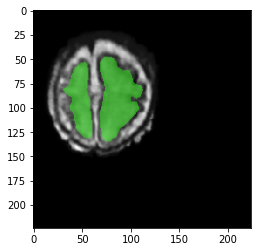

In [17]:
output = output.cpu()
output = torch.argmax(output, 1)[0]
output = torch.nn.functional.one_hot(output).permute((3, 0, 1, 2)).numpy()
print(output.shape)
print(np.sum(output[0]), np.sum(output[1]))

print(f"mask shape = {output.shape}")
plot_semseg(image[0], output, alpha=0.5)
plt.show()

# Resize the mask back

In [18]:
mask = np.argmax(output, axis=0)
maskitk = sitk.GetImageFromArray(mask)

from ptimz.data.transforms import itkimage_resize
maskitk = itkimage_resize(maskitk, origin_size, sitk.sitkNearestNeighbor)
print(maskitk.GetSize())

(256, 256, 256)


# Save mask as nifty

In [19]:
# copy spacing info
maskitk.CopyInformation(imageitk)
print(maskitk.GetSpacing())

out_path = 'sub-001_seg.nii.gz'
sitk.WriteImage(maskitk, out_path)
print(f"Save mask to {out_path}")

(0.5468999743461609, 0.5468999743461609, 0.5468999743461609)
Save mask to sub-001_seg.nii.gz
